In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from Model import FCN
from Dataset import DatasetHandler
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(123)

In [ ]:
class PINN():
    "Defines a PINNs. Input (t, x) => Output (T_f, T_s)"
    def __init__(self, N_INTERIOR, N_INITIAL, N_BOUNDARY):
        self.n_interior_ = N_INTERIOR # number of interior point
        self.n_initial_ = N_INITIAL # number of points for initial condition
        self.n_boundary_ = N_BOUNDARY # number of points for boundary condition

        self.alpha_f = 0.05
        self.alpha_s = 0.08
        self.h_f = 5 # heat transfer fluid
        self.h_s = 6 # heat transfer solid
        self.T_hot = 4
        self.T_0 = 1
        self.u_f = 1 # thermal_conductivity

        # Set extrema for solution domain of t and x
        self.domain_boundaries = torch.tensor([[0.0,1.0], [0.0,1.0]])

        self.model = FCN(IN_DIM=self.domain_boundaries.shape[0], OUT_DIM=2,
                                            N_HIDDEN_LAYERS=4, N_NEURONS=20, REGULARIZE_PARAM=0.,
                                            REGULARIZE_EXP=2.)

        # Sobol sequence generator for input sampling
        self.sobol_gen = torch.quasirandom.SobolEngine(dimension=self.domain_boundaries.shape[0])
        self.dataset_handler = DatasetHandler(self.sobol_gen, self.domain_boundaries)
        self.training_sets = self.dataset_handler.create_datasets(self.n_interior_, self.n_boundary_, self.n_initial_)
        # [interior_points, boundary_loader, initial_loader]
        # note: only input_batch, because output_batch is not defined for PDE problems

    def compute_initial_loss(self, initial_points):
        """"
        Compute sum of residual in the initial condition: Tf(x,t=0) + Ts(x,t=0).
        In the initial condition, this expression is supposed to be 0.

        Params:
        initial_points (tensor): 2D tensor of boundary points, shape of [n_points, 2]

        Returns:
        initial_residual (tensor): sum of residual in initial condition
        """
        #initial_points.requires_grad=True
        predictions_t0 = self.model(initial_points)
        Tf_t0_pred = predictions_t0[:,0]
        Ts_t0_pred = predictions_t0[:,1]

        Tf_t0_loss = torch.mean((Tf_t0_pred - self.T_0) ** 2)  # MSE for T_f
        Ts_t0_loss = torch.mean((Ts_t0_pred - self.T_0) ** 2)  # MSE for T_s

        # Total initial residual (average over all points)
        initial_residual = Tf_t0_loss + Ts_t0_loss

        return initial_residual

    def compute_boundary_loss(self, boundary_points):
        # boundary_points (tensor): 2D tensor of boundary points [n_points, 2]
        # boundary (2)
        boundary_points.requires_grad=True

        mask_x0 = boundary_points[:, 0] == self.domain_boundaries[1, 0]
        mask_xL = boundary_points[:, 0] == self.domain_boundaries[1, 1]

        boundary_points_x0 = boundary_points[mask_x0]
        boundary_points_xL = boundary_points[mask_xL]
        t_boundary_x0 = boundary_points_x0[:, 1]

        predictions_x0 = self.model(boundary_points_x0)
        predictions_xL = self.model(boundary_points_xL)

        Tf_x0_pred, Ts_x0_pred = predictions_x0[:, 0], predictions_x0[:, 1]
        Tf_xL_pred, Ts_xL_pred = predictions_xL[:, 0], predictions_xL[:, 1]


        T_boundary = (self.T_hot - self.T_0) / (1 + torch.exp(-20*(t_boundary_x0-0.25))) + self.T_0 # this sigmoid is very steep

        boundary_2_loss = torch.mean((T_boundary - Tf_x0_pred)**2)

        # Boundary conditions 1
        dTs_x0 = torch.autograd.grad(Ts_x0_pred.sum(), boundary_points_x0, create_graph=True)[0][:,0]
        dTs_xL = torch.autograd.grad(Ts_xL_pred.sum(), boundary_points_xL, create_graph=True)[0][:,0]
        dTf_xL = torch.autograd.grad(Tf_xL_pred.sum(), boundary_points_xL, create_graph=True)[0][:,0] # get dx column, not dt

        boundary_1_loss = torch.mean(dTs_x0**2 + dTs_xL**2 + dTf_xL**2)
        boundary_loss = boundary_1_loss + boundary_2_loss

        #boundary_1_residual = abs(dTs_x0) + abs(dTs_xL) + abs(dTf_xL)

        return boundary_loss # boundary_1_residual.reshape(-1,1), boundary_2_residual.reshape(-1,1)

    def compute_pde_loss(self, interior_points):
        interior_points.requires_grad = True
        predictions = self.model(interior_points)

        Tf_pred = predictions[:, 0]
        Ts_pred = predictions[:, 1]

        dTf = torch.autograd.grad(Tf_pred.sum(), interior_points, create_graph=True)[0]
        dTs = torch.autograd.grad(Ts_pred.sum(), interior_points, create_graph=True)[0]

        dTf_dx = dTf[:, 0]
        dTf_dt = dTf[:, 1]
        dTs_dx = dTs[:, 0]
        dTs_dt = dTs[:, 1]

        d2Tf = torch.autograd.grad(dTf.sum(), interior_points, create_graph=True)[0]
        d2Ts = torch.autograd.grad(dTs.sum(), interior_points, create_graph=True)[0]

        d2Ts_dx2 = d2Ts[:,0]
        d2Tf_dx2 = d2Tf[:,0]

        residual_fluid = (dTf_dt) + (self.u_f * dTf_dx) - (self.alpha_f * d2Tf_dx2) + (self.h_f * (Tf_pred - Ts_pred))
        residual_solid = (dTs_dt) - (self.alpha_s * d2Ts_dx2) - (self.h_s * (Tf_pred - Ts_pred))

        fluid_loss = torch.mean(residual_fluid**2)
        solid_loss = torch.mean(residual_solid**2)

        total_loss = fluid_loss + solid_loss
        return total_loss

    def compute_loss(self, interior_data, boundary_data, initial_data):
        # data in 2D tensor
        boundary_loss = self.compute_boundary_loss(boundary_data)
        initial_loss = self.compute_initial_loss(initial_data)
        pde_loss = self.compute_pde_loss(interior_data)
        total_loss = initial_loss + pde_loss + boundary_loss
        condition_loss = boundary_loss + initial_loss
        #print("Total loss: ", round(total_loss.item(), 4), "| PDE Loss: ", round(pde_loss.item(), 4), "| Conditions Loss: ", round(boundary_loss.item() + initial_loss.item(), 4))
        return condition_loss, pde_loss, total_loss

    def fit(self, epochs, optimizer):
        history = [] # loss history
        for batch in zip(*self.training_sets):
            [interior_points_, boundary_points_, initial_points_] = batch
        for epoch in range(epochs):

            optimizer.zero_grad()
            condition_loss, pde_loss, total_loss = self.compute_loss(interior_points_[0], boundary_points_[0], initial_points_[0])
            total_loss.backward()
            history.append(total_loss.item())

            optimizer.step()

            if (epoch % 500 == 0):
                print(f"Epoch {epoch}")
                print(f"Total loss: {round(total_loss.item(), 4)} | PDE Loss: {round(pde_loss.item(), 4)} | Conditions Loss: {round(condition_loss.item(), 4)}")
                self.visualize_results()

        return history

    def visualize_results(self):
        # solver
        test_points = self.sobol_gen.draw(10000)
        output = self.model(test_points)

        Tf_pred = output[:, 0].reshape(-1,)
        Ts_pred = output[:, 1].reshape(-1,)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

        # Plot for Tf
        im1 = axs[0].scatter(test_points[:, 0].detach(), test_points[:, 1].detach(), c=Tf_pred.detach(), cmap="jet")
        axs[0].set_xlabel("Position (x)")
        axs[0].set_ylabel("Time (t)")
        axs[0].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution $T_f$")
        # Colorbar for Tf plot
        cbar1 = plt.colorbar(im1, ax=axs[0])
        cbar1.set_label("Temperature $T_f$", rotation=270, labelpad=15)

        # Plot for T_s
        im2 = axs[1].scatter(test_points[:, 0].detach(), test_points[:, 1].detach(), c=Ts_pred.detach(), cmap="jet")
        axs[1].set_xlabel("Position (x)")
        axs[1].set_ylabel("Time (t)")
        axs[1].grid(True, which="both", ls=":")
        axs[1].set_title("Approximate Solution $T_s$")

        cbar2 = plt.colorbar(im2, ax=axs[1])
        cbar2.set_label("Temperature $T_s$", rotation=270, labelpad=15)

        plt.show()

Epoch 0
Total loss: 16.7369 | PDE Loss: 1.1591 | Conditions Loss: 15.5777


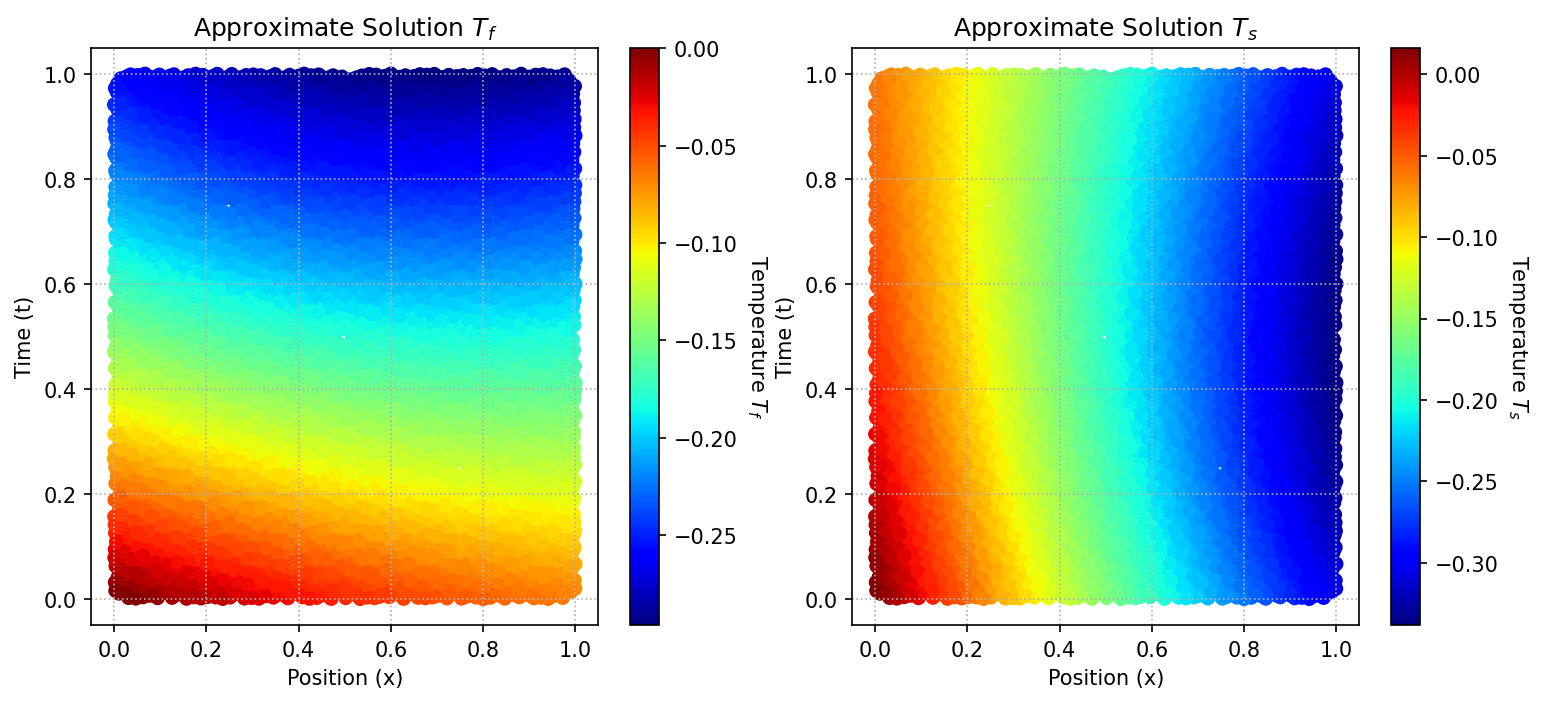

Epoch 500
Total loss: 0.7317 | PDE Loss: 0.1502 | Conditions Loss: 0.5815


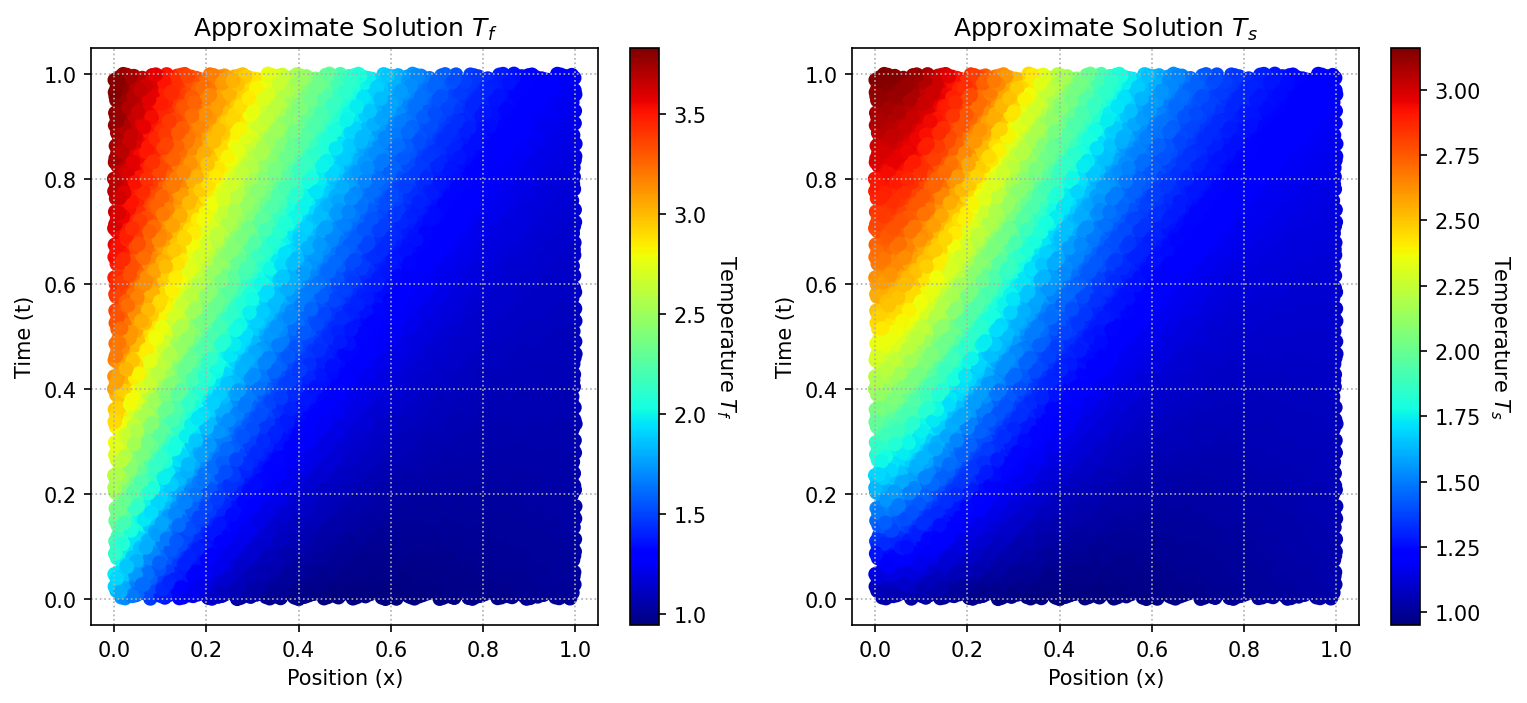

Epoch 1000
Total loss: 0.1153 | PDE Loss: 0.021 | Conditions Loss: 0.0943


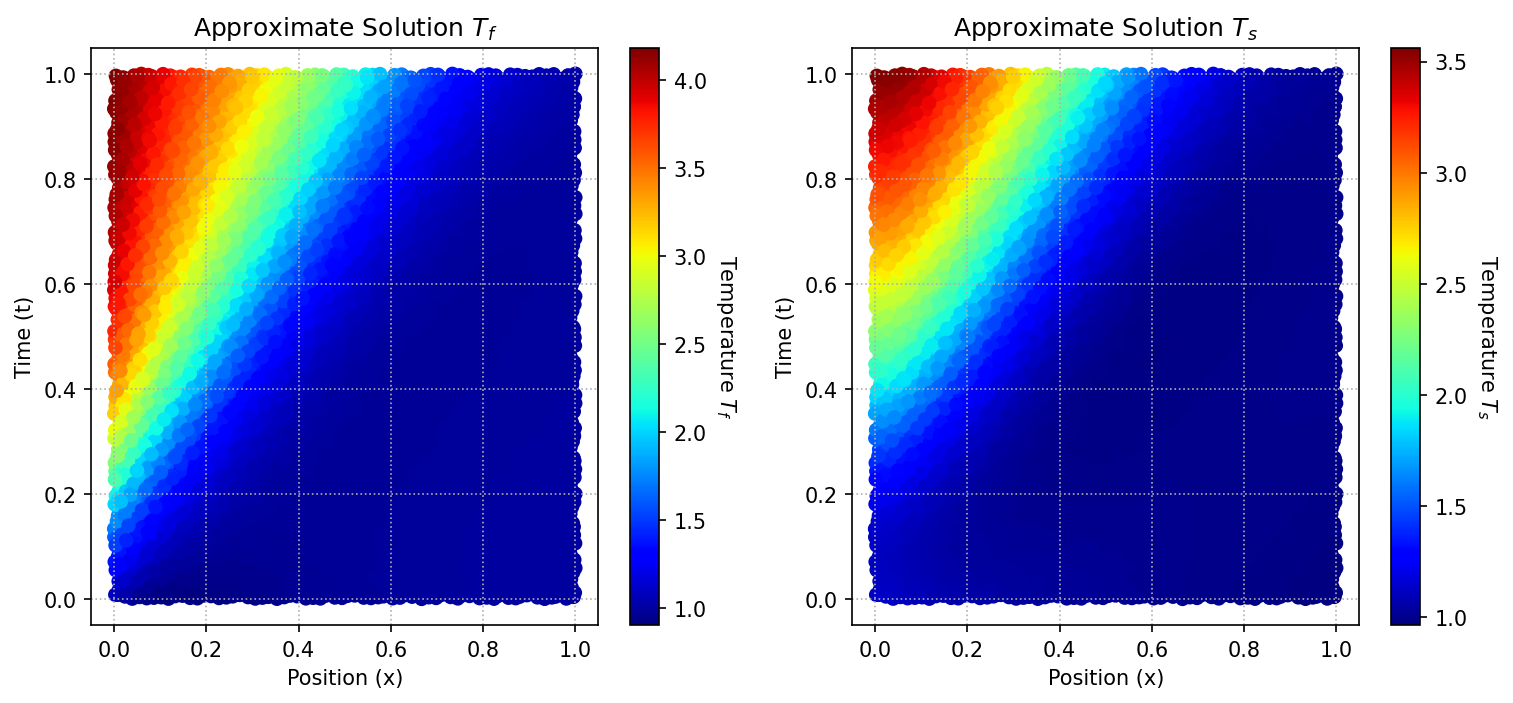

Epoch 1500
Total loss: 0.0331 | PDE Loss: 0.0139 | Conditions Loss: 0.0192


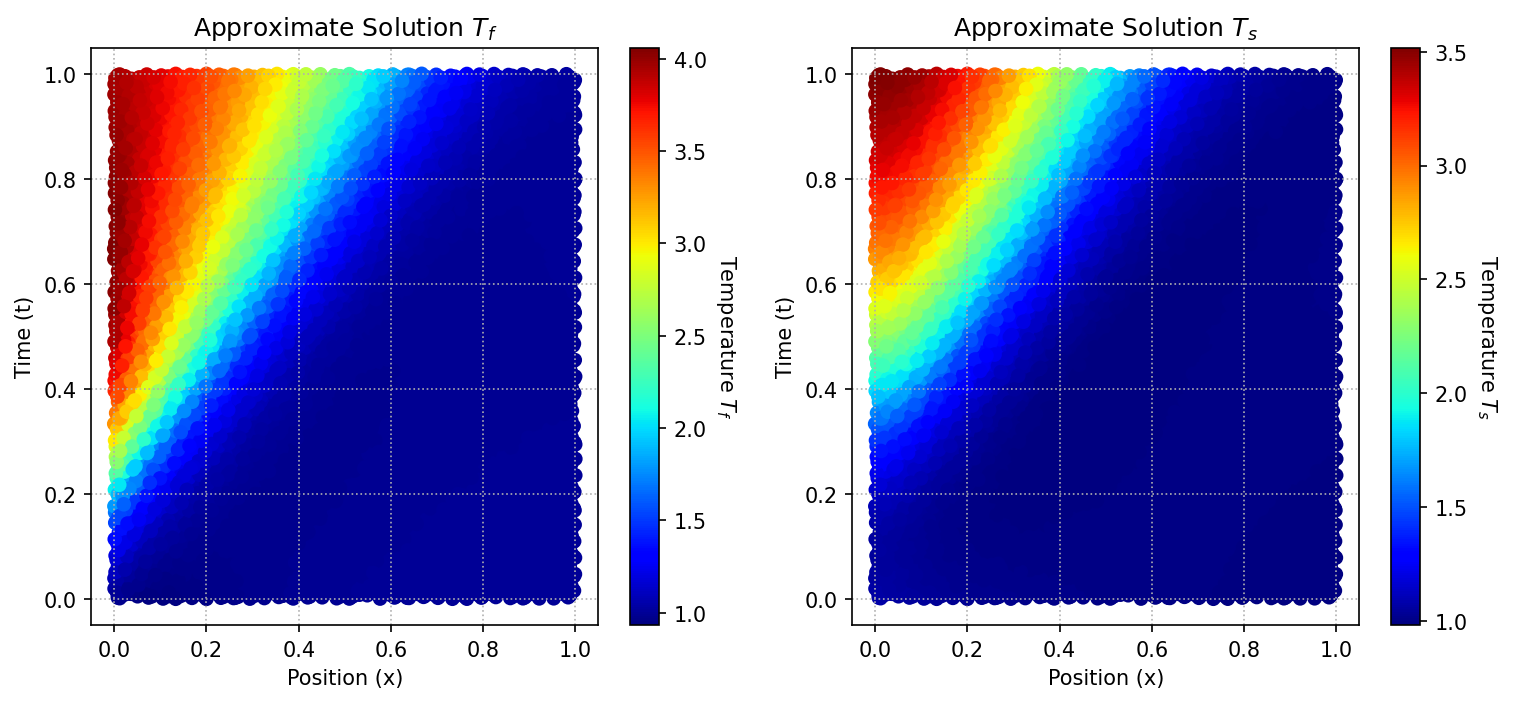

Epoch 2000
Total loss: 0.0156 | PDE Loss: 0.0091 | Conditions Loss: 0.0065


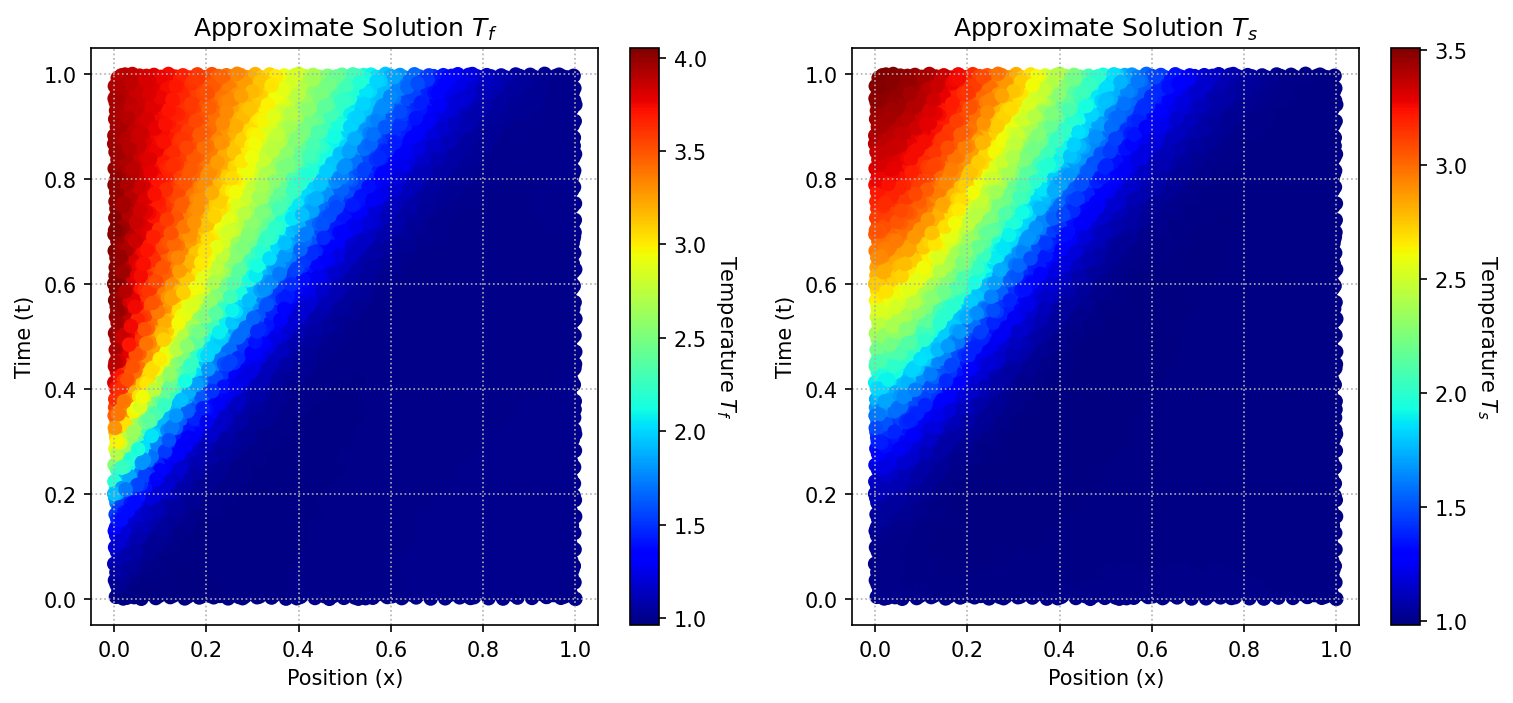

Epoch 2500
Total loss: 0.0101 | PDE Loss: 0.0063 | Conditions Loss: 0.0038


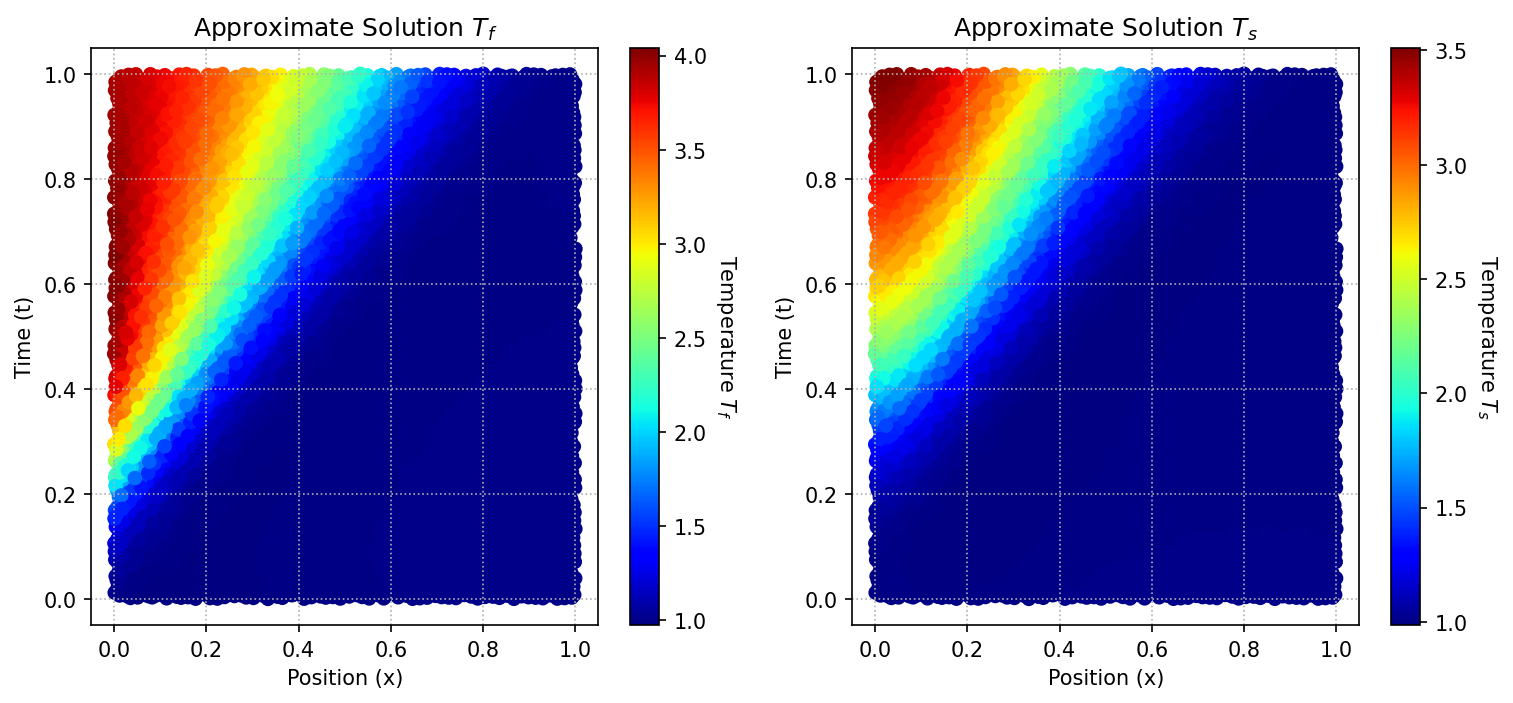

Epoch 3000
Total loss: 0.0073 | PDE Loss: 0.0047 | Conditions Loss: 0.0026


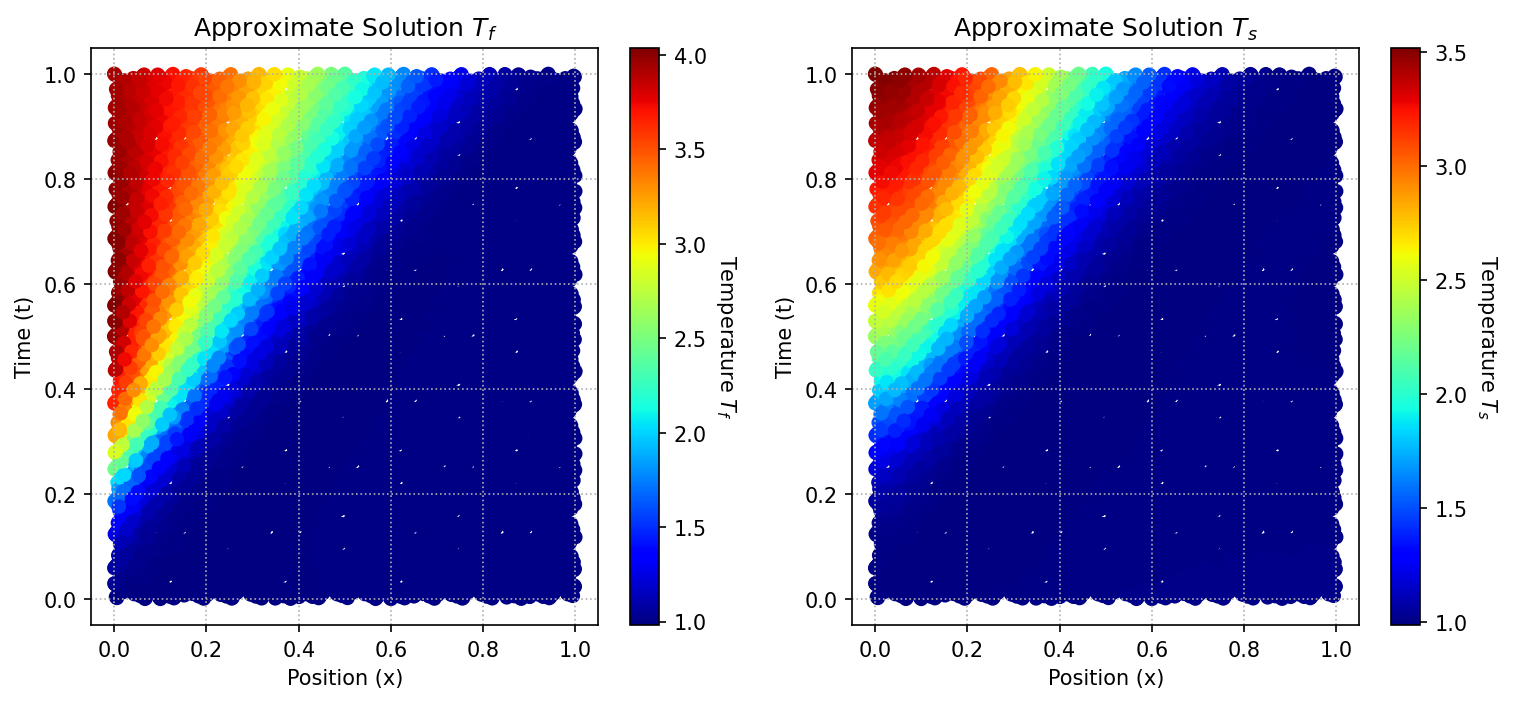

Epoch 3500
Total loss: 0.0058 | PDE Loss: 0.0037 | Conditions Loss: 0.0021


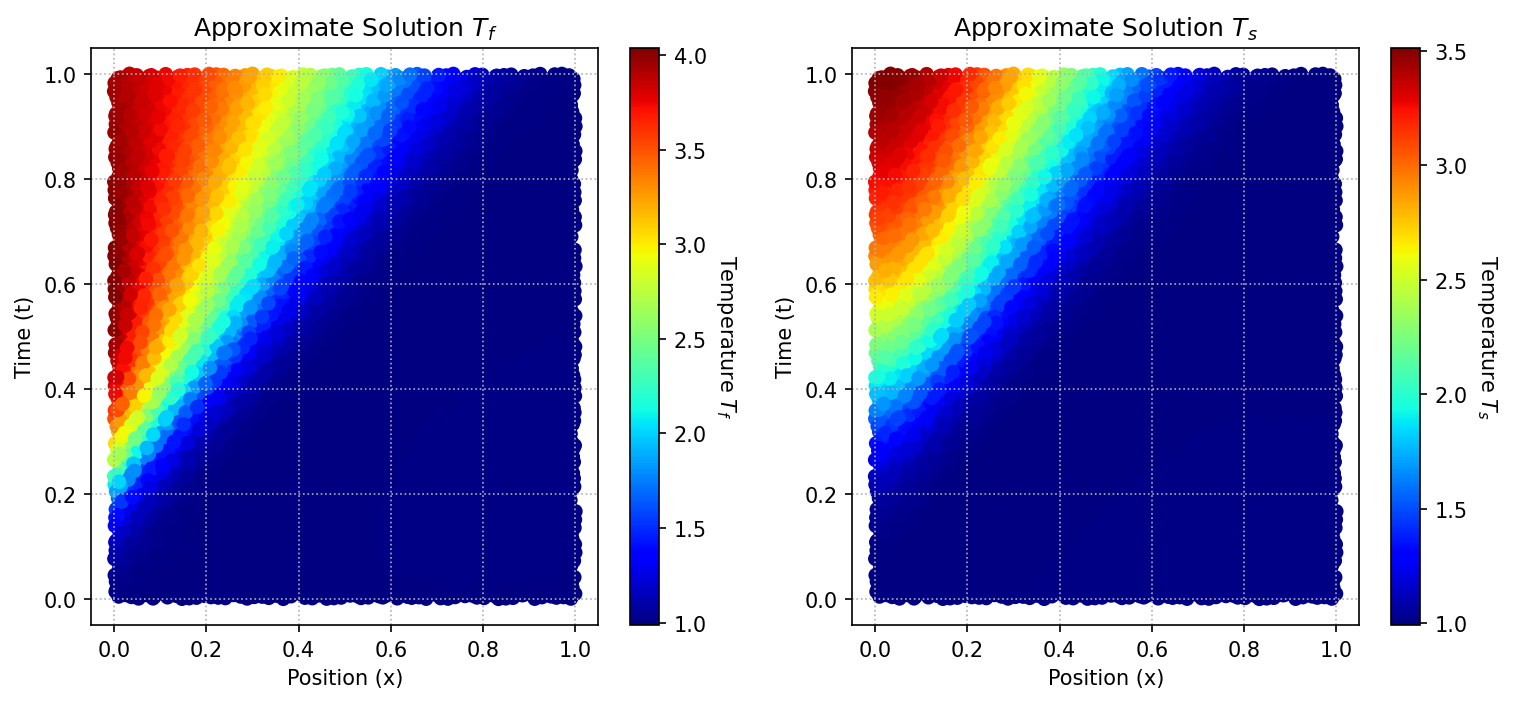

Epoch 4000
Total loss: 0.0048 | PDE Loss: 0.0031 | Conditions Loss: 0.0017


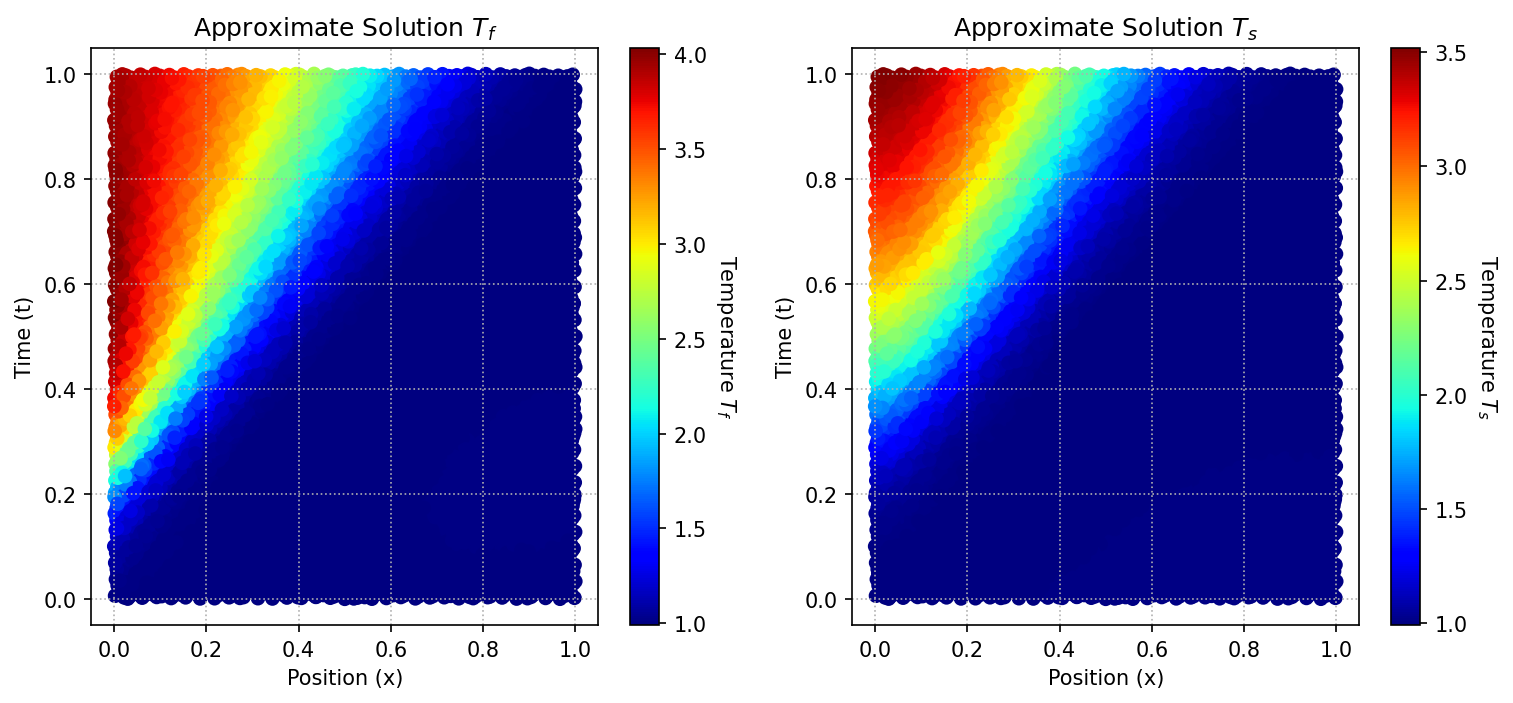

Epoch 4500
Total loss: 0.0061 | PDE Loss: 0.0045 | Conditions Loss: 0.0016


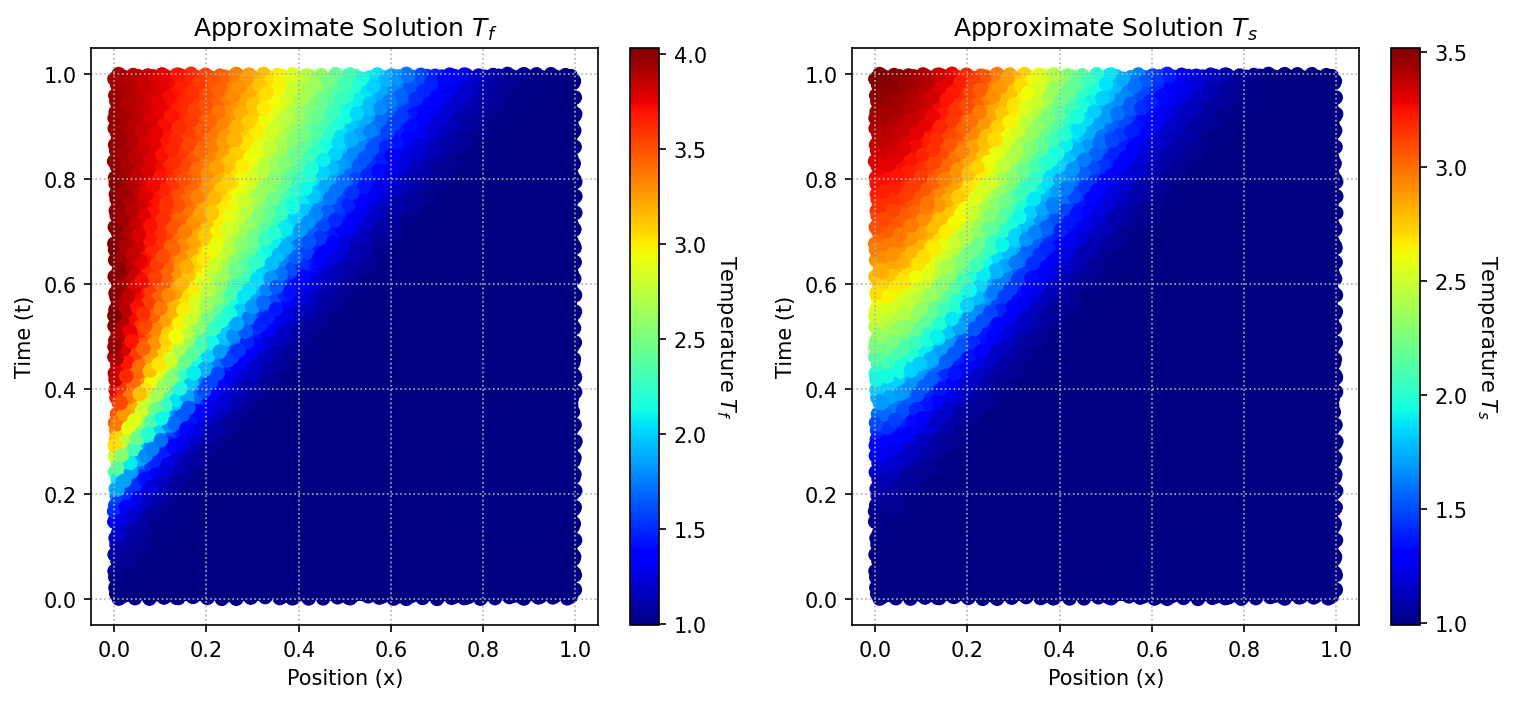

In [ ]:
# Define hyperparameters
n_points = 256
n_boundary = 64
n_initial = 64

solver = PINN(n_points, n_boundary, n_initial)
optimizer_ADAM = optim.Adam(solver.model.parameters(), lr=0.001)
history = solver.fit(epochs=5000, optimizer=optimizer_ADAM)

In [ ]:
# Save the model
torch.save(solver.model.state_dict(), 'hyperparameters.pth')
solver.model.load_state_dict(torch.load("hyperparameters.pth"))

<ipython-input-11-d5ba92c9b6c3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solver.model.load_state_dict(torch.load("hyperparameters.pth"))


<All keys matched successfully>

In [ ]:
# model summary
summary(solver.model, input_size=(10000,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 240, 20]              60
              Tanh-2              [-1, 240, 20]               0
            Linear-3              [-1, 240, 20]             420
              Tanh-4              [-1, 240, 20]               0
            Linear-5              [-1, 240, 20]             420
              Tanh-6              [-1, 240, 20]               0
            Linear-7              [-1, 240, 20]             420
              Tanh-8              [-1, 240, 20]               0
            Linear-9               [-1, 240, 2]              42
Total params: 1,362
Trainable params: 1,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.01
Estimated Total Size (MB): 0.30
-----------------------------------------------